In [ ]:
import sys
import xarray as xr
sys.path.append(r'C:\Users\everett\Documents\GitHub\camus_to')



data_file = r"C:\Users\everett\Documents\GitHub\camus_to\data\clean\camus_to.nc"


station_id = "HY006"





,stage,discharge,temperature,precipitation
station,HY006,HY006,HY006,HY006
time,,,,
2015-01-01 00:15:00,False,False,False,False
2015-01-01 00:30:00,False,False,False,False
2015-01-01 00:45:00,False,False,False,False
2015-01-01 01:00:00,False,False,False,False
2015-01-01 01:15:00,False,False,False,False
...,...,...,...,...
2021-02-05 18:00:00,False,False,False,False
2021-02-05 18:15:00,False,False,False,False


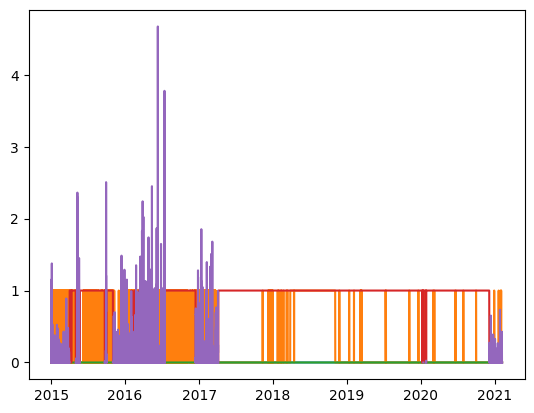

In [70]:
plt.plot(df.isna())
plt.plot(df["precipitation"])

In [56]:
import pandas as pd
df

,stage,discharge,temperature,precipitation
station,HY006,HY006,HY006,HY006
time,,,,
2015-01-01 00:15:00,0.252772,0.010861,-7.433333,0.000000
2015-01-01 00:30:00,0.254771,0.010996,-7.408333,0.000000
2015-01-01 00:45:00,0.256771,0.011030,-7.383333,0.000000
2015-01-01 01:00:00,0.259771,0.011064,-7.358333,0.000000
2015-01-01 01:15:00,0.261771,0.010928,-7.416667,0.095586
...,...,...,...,...
2021-02-05 18:00:00,0.275583,0.009178,-7.220000,0.000000
2021-02-05 18:15:00,0.275583,0.009114,-7.295000,0.000000
